# Imports

In [ ]:
from os import listdir
from os.path import isfile, join
import librosa
import numpy as np
import tensorflow as tf
import os
import pprint
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow
from scipy.io import wavfile
from scipy.io.wavfile import write
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Conv2D, Reshape, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Constants

In [ ]:
target_audio_path = "/content/drive/MyDrive/Colab Notebooks/CS230 Project/datasets/NonNative/bangla_s01_000.wav"
non_native_path = "/content/drive/MyDrive/Colab Notebooks/CS230 Project/datasets/NonNative/bangla_s01_000.wav"
native_path = "/content/drive/MyDrive/Colab Notebooks/CS230 Project/datasets/Native/american_s02_571.wav"

native_speaker_path = '/content/drive/MyDrive/Colab Notebooks/CS230 Project/datasets/Native'
non_native_speaker_path = '/content/drive/MyDrive/Colab Notebooks/CS230 Project/datasets/NonNative'
pre_train_model_weights_file = '/content/drive/MyDrive/Colab Notebooks/CS230 Project/model_weights/my_model_weights_accuracy_of_1.0_2023-06-04_11-11-02.h5'

num_classes = 1 # is native accent

STYLE_LAYERS = [
    ('conv1', 0.4),
    ('conv2', 0.1),
    ('conv3', 0.1),
    ('conv4', 0.1)]

CONTENT_LAYER =[('conv3', 1)]

# Hyper Parameters

In [ ]:
img_size = 512
num_of_epochs = 8
learning_rate = 0.001
audio_duration = 10
patience = 5
# Potential Use
# dropout_rate = 0.2


NST_style_weight = 10
NST_content_weight = 40
NST_num_of_steps = 10000
NST_print_epoch = 200

#Data Preprocessing

In [ ]:
def slice_audio(audio, sr, slice_duration = audio_duration):
    # Calculate the total duration of the audio in seconds
    total_duration = librosa.get_duration(y=audio, sr=sr)

    # Improvment - use Augmentation to combin the data in diffrent varations - volume..
    # Check if the audio is shorter than the desired slice_duration
    if total_duration < slice_duration:
        # Calculate the number of times the audio needs to be duplicated
        num_duplicates = int(slice_duration // total_duration) + 1
        # Duplicate the audio
        audio = np.tile(audio, num_duplicates)
        # Update the total duration
        total_duration = librosa.get_duration(y=audio, sr=sr)

    # Calculate the number of slices needed
    num_slices = int(total_duration // slice_duration)

    # Initialize an empty list to store the audio slices
    audio_slices = []

    # Cut the audio into slices
    for i in range(num_slices):
        start_time = i * slice_duration
        end_time = start_time + slice_duration
        start_sample = int(start_time * sr)
        end_sample = int(end_time * sr)

        slice_audio = audio[start_sample:end_sample]
        audio_slices.append(slice_audio)

    return audio_slices

def audio_to_spectrograms(source_audio_path):
    log_mel_spectrograms = []
    # Load audio file
    source_audio, sr = librosa.load(source_audio_path, sr=None)
    _ , target_sr = librosa.load(target_audio_path, sr=None)

    source_audio_segments = slice_audio(source_audio, sr)
    for seg in source_audio_segments:
      # Resemble audio to fixed length
      audio = librosa.resample(seg, orig_sr=sr, target_sr=target_sr, fix=True)

      # Compute Mel spectrogram
      mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
      log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
      log_mel_spectrograms.append(log_mel_spectrogram)

    #print("audio_to_spectrograms :: For " + source_audio_path +
    #      " Generated spectrogram shape is - " + str(log_mel_spectrogram.shape))

    return log_mel_spectrograms


def pre_processing_data(accent_ref_dir_path, native_path, target_file_path):
    style_speaker_data = []

    for f in listdir(accent_ref_dir_path):
        file_name = join(accent_ref_dir_path, f)
        if isfile(file_name):
            style_speaker_data.append(file_name)

    accent_style_speaker_spectrograms = [audio_to_spectrograms(path) for path in style_speaker_data]

    spectrogram_non_native = audio_to_spectrograms(target_file_path)
    spectrogram_native = audio_to_spectrograms(native_path)

    # ensure that all input spectrograms have the same shape before
    allSpec = accent_style_speaker_spectrograms.copy()
    allSpec.append(spectrogram_non_native)
    allSpec.append(spectrogram_native)
    max_shape = np.max([spectrogram.shape for spectrogram in allSpec], axis=0)


    accent_style_speaker_spectrograms = [
        np.pad(spectrogram, ((0, max_shape[0] - spectrogram.shape[0]), (0, max_shape[1] - spectrogram.shape[1])),
               mode='constant') for spectrogram in accent_style_speaker_spectrograms]

    spectrogram_non_native = np.pad(spectrogram_non_native, ((0, max_shape[0] - spectrogram_non_native.shape[0]), (0, max_shape[1] - spectrogram_non_native.shape[1])),
               mode='constant')

    spectrogram_native = np.pad(spectrogram_native, (
    (0, max_shape[0] - spectrogram_native.shape[0]), (0, max_shape[1] - spectrogram_native.shape[1])),
                                    mode='constant')

    return accent_style_speaker_spectrograms, spectrogram_native, spectrogram_non_native


# Required since the original array size is to big for the memory of my laptop
def downsample_spectrogram(spectrogram, factor):

    if factor is None:
        return spectrogram

    # Calculate the new shape of the spectrogram
    new_shape = (spectrogram.shape[0] // factor, spectrogram.shape[1])

    # Reshape the spectrogram to group adjacent frequency bins
    reshaped = spectrogram.reshape(new_shape[0], factor, new_shape[1])

    # Average the grouped frequency bins
    import tensorflow as tf
    downsampled = tf.reduce_mean(reshaped, axis=1)

    return downsampled


def normalize_audio(audio):
    max_amplitude = np.max(np.abs(audio))
    normalized_audio = audio / max_amplitude
    return normalized_audio


def spectrogram_to_audio(spectrogram, sr):
    # Convert spectrogram back to linear scale
    mel_spectrogram = librosa.db_to_power(spectrogram)  # , ref=np.max)

    # Invert Mel spectrogram to raw audio
    audio = librosa.feature.inverse.mel_to_audio(mel_spectrogram, sr=sr, n_fft=2048, hop_length=512)

    return normalize_audio(audio)


def spect_2_vgg_input(log_magnitude):
    # Expand the spectrogram dimensions to have one channel
    log_magnitude = tf.expand_dims(log_magnitude, axis=-1)

    # Resize the spectrogram to img_size x img_size
    log_magnitude = tf.image.resize(log_magnitude, (img_size, img_size))

    # Normalize the spectrogram values to [0, 1]
    log_magnitude = (log_magnitude - tf.reduce_min(log_magnitude)) / (
            tf.reduce_max(log_magnitude) - tf.reduce_min(log_magnitude))

    # Expand the spectrogram dimensions to have 3 channels
    log_magnitude = tf.tile(tf.expand_dims(log_magnitude, axis=-1), [1, 1, 1, 3])
    log_magnitude = tf.expand_dims(tf.squeeze(log_magnitude, axis=2), axis=0)
    # spectrogram = vgg19.preprocess_input(log_magnitude)
    return log_magnitude


def vgg_input_2_spect(vgg_input, original_height, original_width, spectrogram_min, spectrogram_max):
    # Resize the spectrogram to the original size
    output = tf.image.resize(vgg_input, (original_height, original_width))
    output = tf.squeeze(output, axis=0)

    # Reduce color channel dimension
    output = tf.reduce_mean(output, axis=-1)

    # Reverse normalization
    output = output * (spectrogram_max - spectrogram_min) + spectrogram_min

    return output

## Spectogram Examples

1


Text(0, 0.5, 'Frequency')

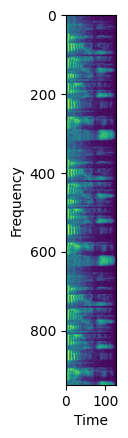

In [ ]:
spectograms = audio_to_spectrograms(non_native_path)
print(len(spectograms))
log_magnitude_non_native = spectograms[0]
# Plot the spectrogram
plt.imshow(tf.transpose(log_magnitude_non_native))
plt.xlabel('Time')
plt.ylabel('Frequency')

1


Text(0, 0.5, 'Frequency')

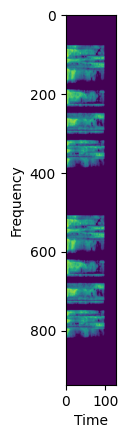

In [ ]:
spectograms = audio_to_spectrograms(native_path)
print(len(spectograms))
log_magnitude_native = spectograms[0]
# Plot the spectrogram
plt.imshow(tf.transpose(log_magnitude_native))
plt.xlabel('Time')
plt.ylabel('Frequency')

## Sanity Check Tests

In [ ]:
def slice_audio_test():
  audio, sr = librosa.load(non_native_path, sr=None)
  slices = slice_audio(audio, sr)
  # Print the number of slices and the duration of each slice
  print("Number of slices:", len(slices))
  for i, seg in enumerate(slices):
      slice_duration = len(seg) / sr
      print("Slice", i+1, "duration:", slice_duration, "seconds")
# slice_audio_test()

In [ ]:
def sanity_check():
    sample_rate, expected_output = wavfile.read(target_audio_path)

    spectrogram = audio_to_spectrograms(target_audio_path)[0]
    generated_audio = spectrogram_to_audio(spectrogram, sample_rate)

    file_name = '/content/drive/MyDrive/Colab Notebooks/CS230 Project/Generated_Audio/SanityCheck_Back_from_spectrogram_' + str(
        datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.wav'
    print("Saving generated audion as - " + file_name)
    write(file_name, sample_rate, generated_audio)

    # Keep a reference to the original spectrogram shape and min/max values
    original_height, original_width = spectrogram.shape
    spectrogram_min = np.min(spectrogram)
    spectrogram_max = np.max(spectrogram)

    # Convert spectrogram into VGG19 input
    vgg19_input = spect_2_vgg_input(spectrogram)

    # Restore VGG19 input back to something similar to the original spectrogram
    restored_spectrogram = vgg_input_2_spect(vgg19_input, original_height, original_width, spectrogram_min,
                                          spectrogram_max)
    output = spectrogram_to_audio(restored_spectrogram, sample_rate)
    file_name = '/content/drive/MyDrive/Colab Notebooks/CS230 Project/Generated_Audio/SanityCheck_Back_from_vggInput2_epochs=' + str(num_of_epochs) + str(
        datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.wav'
    print("SanityCheck :: Saving generated audion as - " + file_name)
    write(file_name, sample_rate, output)

#sanity_check()

# Binary Classifier

## Load Data

In [ ]:
# Function to load audio files from a directory
def load_audio_files(source_path, target_path):
    features = []
    labels = []
    num_of_native_examples = 0
    num_of_non_native_examples = 0
    for filename in os.listdir(source_path):
        if filename.endswith('.wav'):  # Assuming audio files are in WAV format
            audio_file = os.path.join(source_path, filename)
            audios_features = audio_to_spectrograms(audio_file)
            for audio_features in audios_features:
              features.append(audio_features)
              labels.append(1)  # Native English speaker label
              num_of_native_examples += 1

    for filename in os.listdir(target_path):
        if filename.endswith('.wav'):  # Assuming audio files are in WAV format
            audio_file = os.path.join(target_path, filename)
            audios_features = audio_to_spectrograms(audio_file)
            for audio_features in audios_features:
              features.append(audio_features)
              labels.append(0)  # Non Native English speaker label
              num_of_non_native_examples += 1


    print('number of non native examples = ' + str(num_of_non_native_examples))
    print('number of native examples = ' + str(num_of_native_examples))


    return features, labels

def create_data_set():

  # Load audio files for native English speakers

  features, labels = load_audio_files(native_speaker_path, non_native_speaker_path)

  # Convert features and labels to numpy arrays
  X = np.array(features)
  y = np.array(labels)

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = create_data_set()

print(f"Train Set       :: X_train.shape - {X_train.shape}")
print(f"Validation Set  :: X_val.shape - {X_val.shape}")
print(f"Test Set        :: X_test.shape - {X_test.shape}")

number of non native examples = 601
number of native examples = 600
Train Set       :: X_train.shape - (720, 128, 938)
Validation Set  :: X_val.shape - (240, 128, 938)
Test Set        :: X_test.shape - (241, 128, 938)


## Model Architecture

In [ ]:
input_shape = log_magnitude_non_native.shape

In [ ]:
def build_baseline_model(input_shape, num_classes):
    model = tf.keras.Sequential()
    model.add(Reshape((128, input_shape[1], 1), input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv2'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv3'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv4'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))
    plot_model(model, to_file='baseline_model_plot.png', show_shapes=True, show_layer_names=True)
    model.summary()
    return model

def build_model(input_shape, num_classes):
    model = tf.keras.Sequential()
    model.add(Reshape((128, input_shape[1], 1), input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(BatchNormalization()) # added batch normalization layer
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv2'))
    model.add(BatchNormalization()) # added batch normalization layer
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv3'))
    model.add(BatchNormalization()) # added batch normalization layer
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv4'))
    model.add(BatchNormalization()) # added batch normalization layer
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='sigmoid'))
    model.summary()
    return model

### Baseline Model

In [ ]:
baseline_model = build_baseline_model(input_shape, num_classes)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 938, 1)       0         
                                                                 
 conv1 (Conv2D)              (None, 126, 936, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 468, 32)      0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 61, 466, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 233, 64)      0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 28, 231, 128)      7

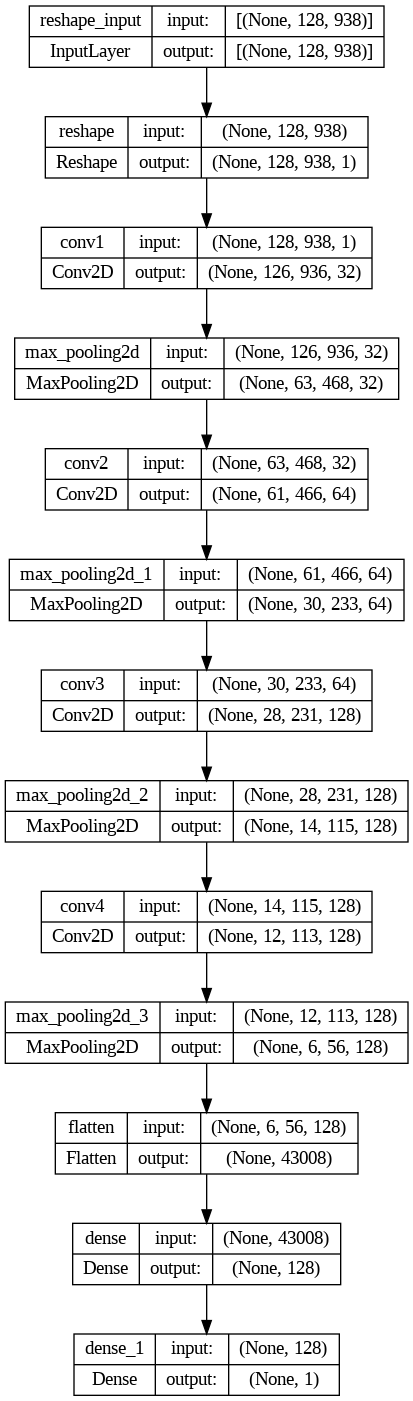

In [ ]:
plot_model(baseline_model, to_file='/content/drive/MyDrive/Colab Notebooks/CS230 Project/Results Plots/baseline_model_plot.png', show_shapes=True, show_layer_names=True)

### Model

In [ ]:
bn_model = build_model(input_shape, num_classes)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 128, 938, 1)       0         
                                                                 
 conv1 (Conv2D)              (None, 126, 936, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 126, 936, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 63, 468, 32)      0         
 2D)                                                             
                                                                 
 conv2 (Conv2D)              (None, 61, 466, 64)       18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 466, 64)     

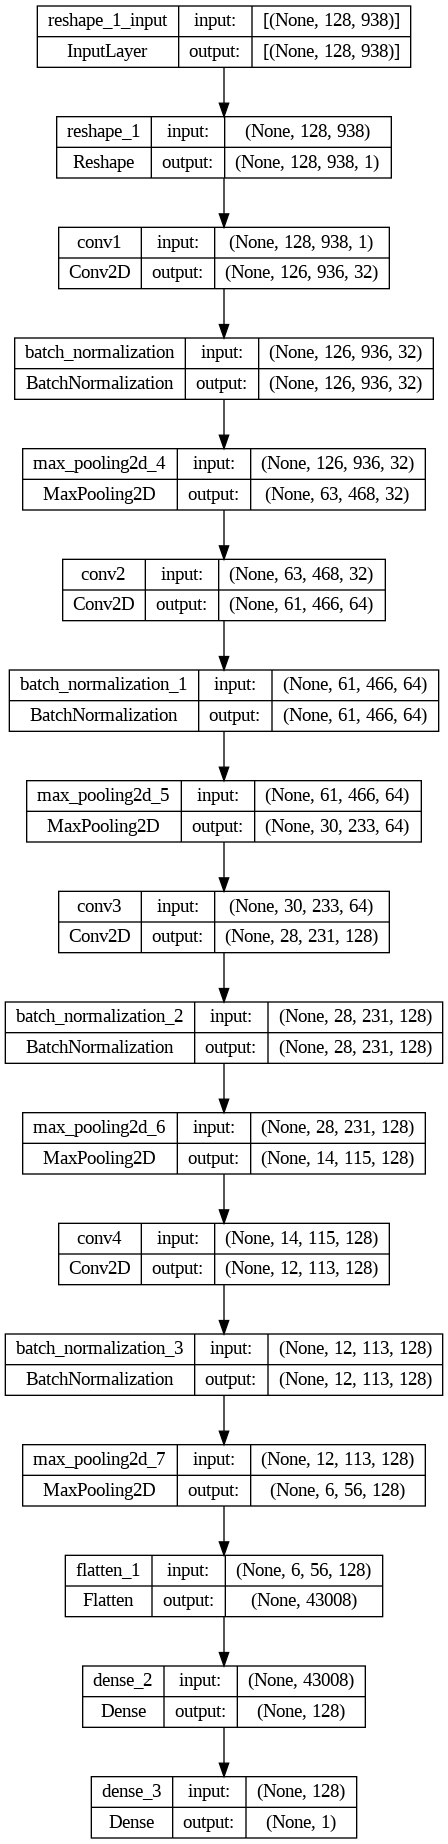

In [ ]:
plot_model(bn_model, to_file='/content/drive/MyDrive/Colab Notebooks/CS230 Project/Results Plots/bn_model_plot.png', show_shapes=True, show_layer_names=True)

## Train

In [ ]:
model = bn_model

In [ ]:
# Declare a global variable to store the training history
global_history = None

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
weights_file_name = '/cont'

has_pre_train_weights = os.path.exists(weights_file_name)
if has_pre_train_weights:
    print("Loading weights_file_name - " + weights_file_name)
    model.load_weights(weights_file_name)
else:
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=METRICS)

    # Define early stopping callback
    early_stop = EarlyStopping(patience=patience, monitor='val_loss', mode='min', restore_best_weights=True)

    print("X_train.shape = " + str(X_train.shape))
    print("y_train.shape = " + str(y_train.shape))

    # Record the start time
    start_time = time.time()

    # Train the model
    global_history = model.fit(X_train, y_train, epochs=num_of_epochs, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])

    # Record the end time
    end_time = time.time()

    # Calculate the training time
    training_time = end_time - start_time
    print('Training time:', training_time)

    # Evaluate the model
    evaluation_metrics = model.evaluate(X_test, y_test)
    loss = evaluation_metrics[0]
    accuracy = evaluation_metrics[1]
    print('Test Loss:', loss)
    print('Test Accuracy:', accuracy)

    #print plot
    print(global_history.history['val_accuracy'])

    # Save the weights_
    weights_file_name = f'/content/drive/MyDrive/Colab Notebooks/CS230 Project/model_weights/batch_norm__model_weights_accuracy_of_{accuracy}_' + str(datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.h5'
    model.save_weights(weights_file_name)

    print("Saving weights in - " + weights_file_name)


In [ ]:
#model = build_model(input_shape, num_classes)
#to_load = '/content/drive/MyDrive/Colab Notebooks/CS230 Project/model_weights/my_model_weights_accuracy_of_0.9958506226539612_2023-06-05_21-12-30.h5'
#model.load_weights(to_load)

## Evaluation

In [ ]:
def evaluate_test_set(model):
  evaluation_metrics = model.evaluate(X_test, y_test)
  loss = evaluation_metrics[0]
  accuracy = evaluation_metrics[1]
  print('Test Loss:', loss)
  print('Test Accuracy:', accuracy)

def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    # Plot loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def plot_evaluation(y_true, y_prob):
    # Calculate predicted labels based on the probability threshold of 0.5
    y_pred = np.round(y_prob)

    # Calculate accuracy and loss
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    loss = -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))

    print("Accuracy: {:.2f}%".format(accuracy * 100))
    print("Loss: {:.4f}".format(loss))

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label="ROC curve (AUC = {:.2f})".format(auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    classes = ['Non-Native', 'Native']

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


### Validation

#### Baseline Model

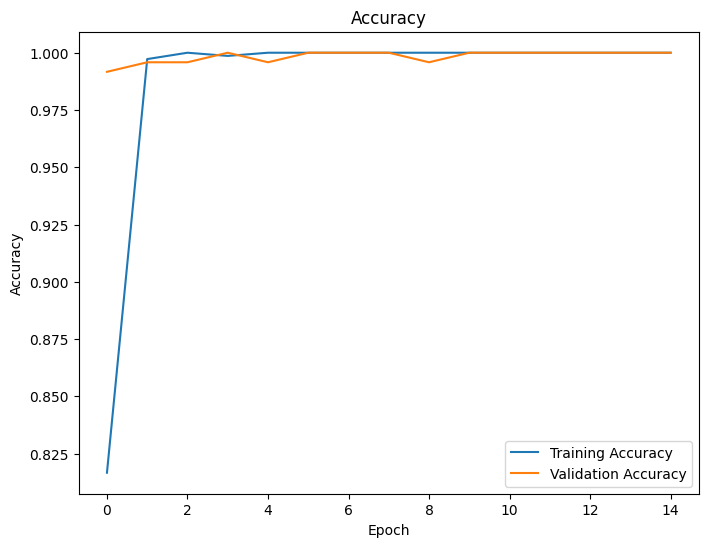

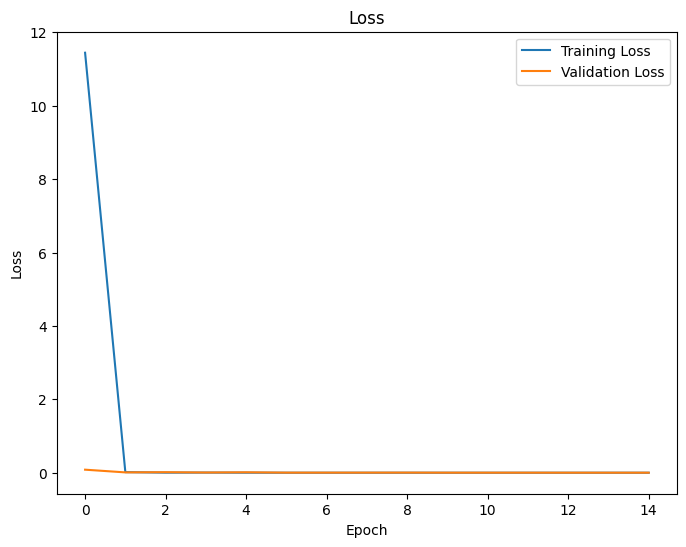

8/8 [==============================] - 0s 26ms/step
Accuracy: 12003.33%
Loss: nan


<ipython-input-24-b964fa733cb4>:35: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))
<ipython-input-24-b964fa733cb4>:35: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))


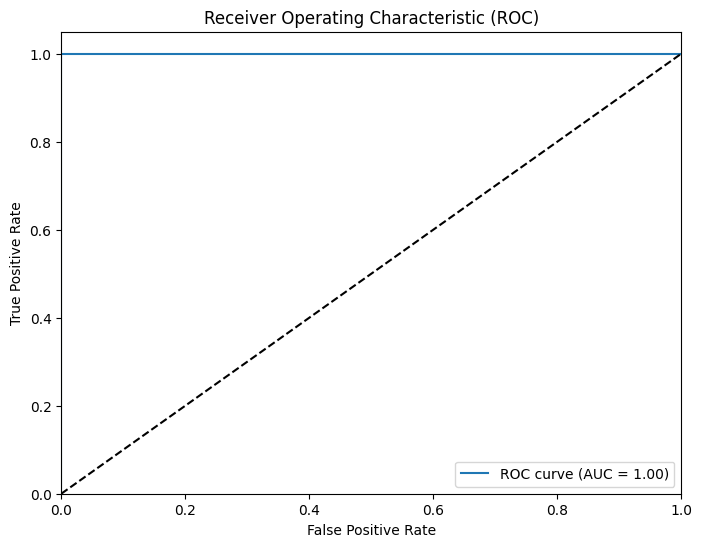

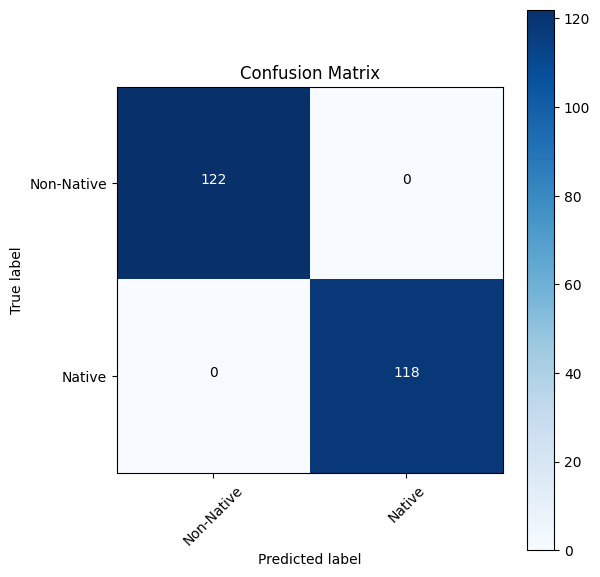

In [ ]:
plot_history(global_history)
plot_evaluation(y_val, baseline_model.predict(X_val))

#### Model

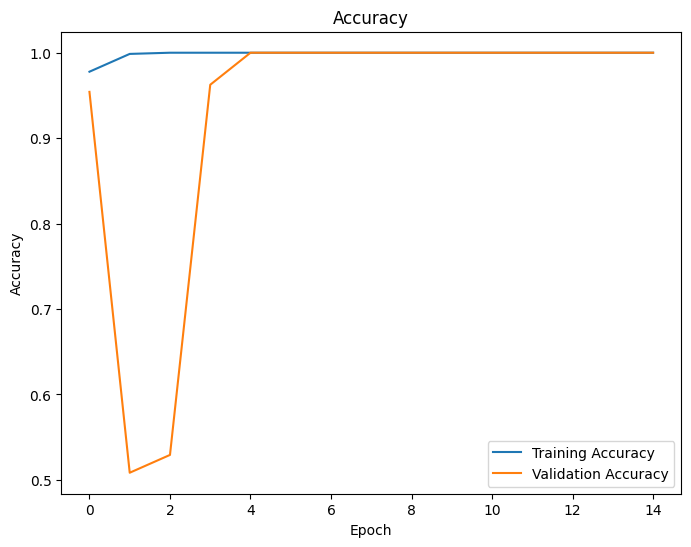

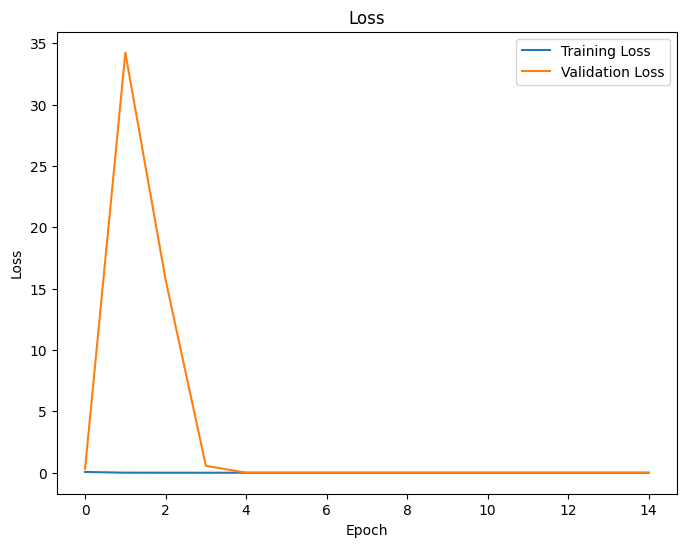

8/8 [==============================] - 0s 41ms/step
Accuracy: 12003.33%
Loss: nan


<ipython-input-24-b964fa733cb4>:35: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))
<ipython-input-24-b964fa733cb4>:35: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))


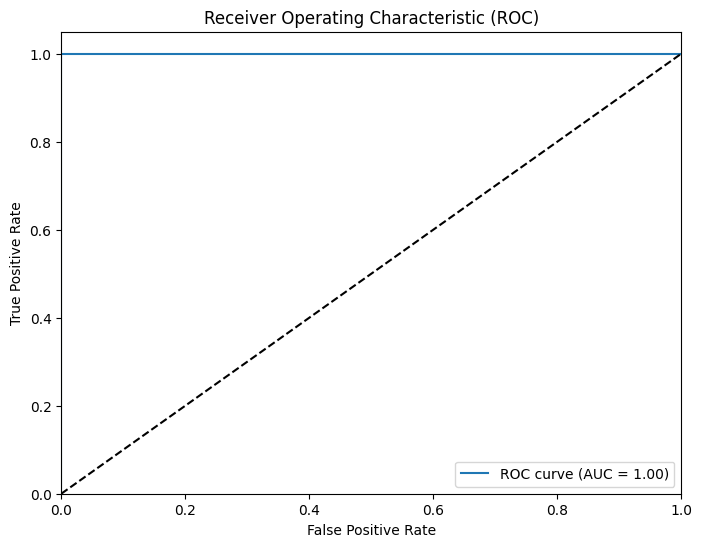

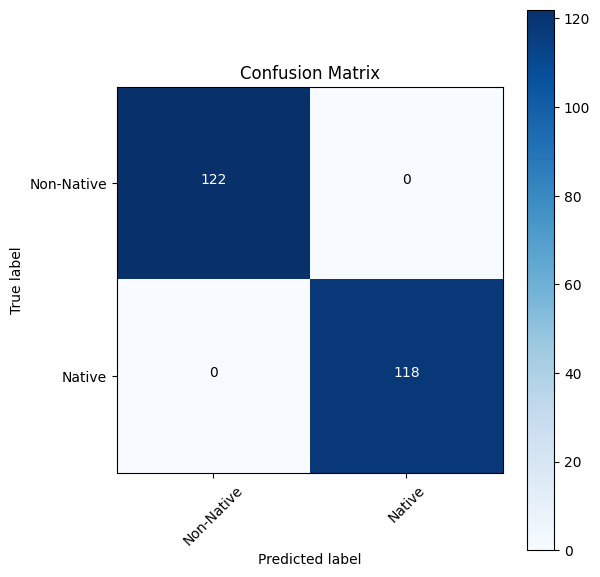

In [ ]:
plot_history(global_history)
plot_evaluation(y_val, model.predict(X_val))

### Test set

#### Baseline Model

8/8 [==============================] - 1s 105ms/step - loss: 6.2725e-05 - accuracy: 1.0000 - tp: 139.0000 - fp: 0.0000e+00 - tn: 102.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Test Loss: 6.272466998780146e-05
Test Accuracy: 1.0
8/8 [==============================] - 0s 25ms/step
Accuracy: 12334.02%
Loss: nan


<ipython-input-24-b964fa733cb4>:35: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))
<ipython-input-24-b964fa733cb4>:35: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))


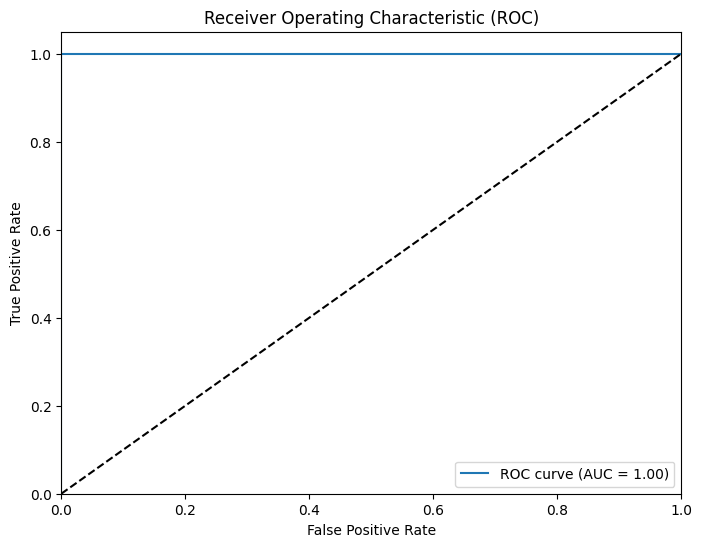

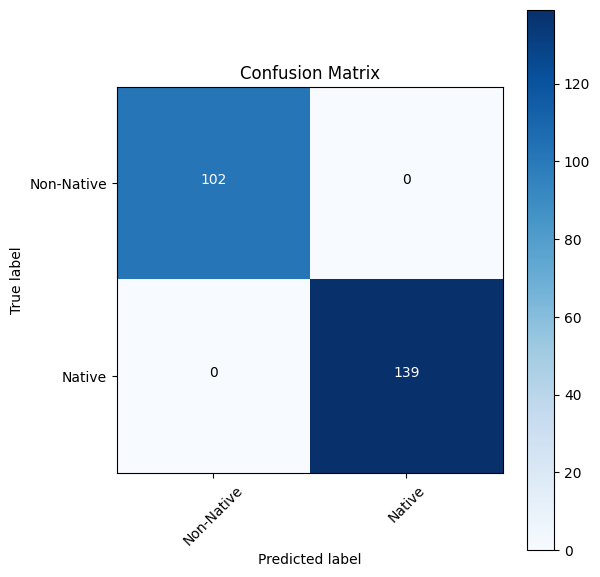

In [ ]:
evaluate_test_set(baseline_model)
plot_evaluation(y_test, baseline_model.predict(X_test))

#### Model

8/8 [==============================] - 0s 51ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - tp: 139.0000 - fp: 0.0000e+00 - tn: 102.0000 - fn: 0.0000e+00 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - prc: 1.0000
Test Loss: 0.0
Test Accuracy: 1.0
8/8 [==============================] - 0s 37ms/step
Accuracy: 12334.02%
Loss: nan


<ipython-input-24-b964fa733cb4>:35: RuntimeWarning: divide by zero encountered in log
  loss = -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))
<ipython-input-24-b964fa733cb4>:35: RuntimeWarning: invalid value encountered in multiply
  loss = -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))


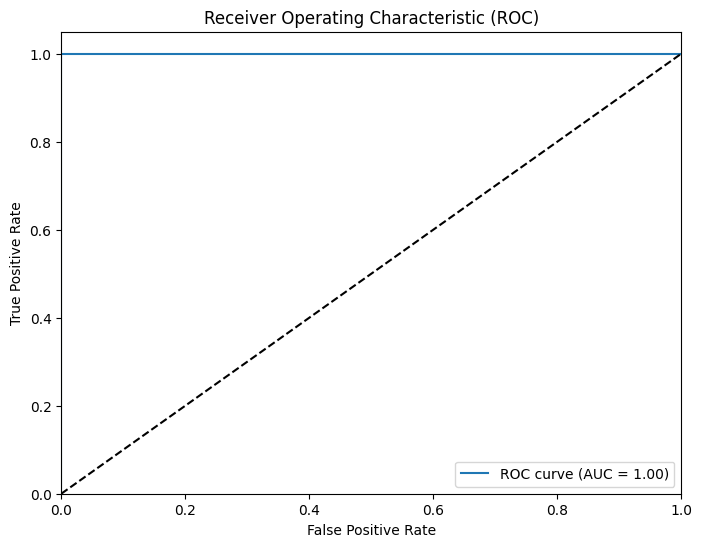

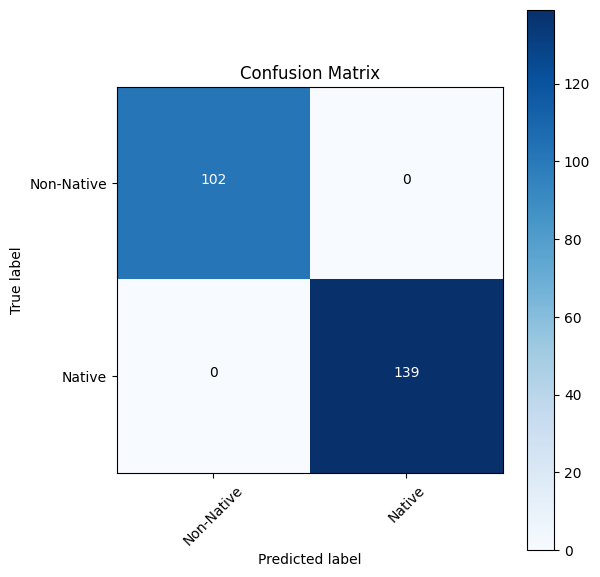

In [ ]:
evaluate_test_set(model)
plot_evaluation(y_test, model.predict(X_test))

# Audio Style Transfer

## Model

In [ ]:
# Function to compute gram matrix
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / (num_locations)

# Compute content loss
def compute_content_loss(content_features, generated_features):
    return tf.reduce_mean(tf.square(content_features - generated_features))

# Compute style loss
def compute_style_loss(style_features, generated_features):
    style_gram = gram_matrix(style_features)
    generated_gram = gram_matrix(generated_features)
    return tf.reduce_mean(tf.square(style_gram - generated_gram))

In [ ]:
# Get the Encoder using pre-trained classifiers
encoder = tf.keras.models.clone_model(model)
encoder.pop()

# Define the model for computing content and style features
content_model = tf.keras.models.Model(inputs=encoder.input, outputs=[encoder.get_layer(layer[0]).output for layer in CONTENT_LAYER])
style_model = tf.keras.models.Model(inputs=encoder.input, outputs=[encoder.get_layer(layer[0]).output for layer in STYLE_LAYERS])

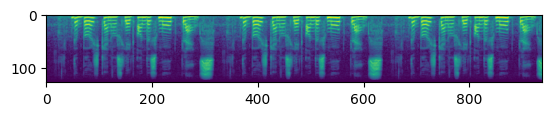

In [ ]:
non_native_spectrograms = audio_to_spectrograms(target_audio_path)
non_native_spectrogram = non_native_spectrograms[0]

native_spectrograms = audio_to_spectrograms(native_path)
native_spectrogram = native_spectrograms[0]

generated_image = tf.Variable(tf.image.convert_image_dtype(non_native_spectrogram, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)

imshow(generated_image.numpy())

In [ ]:
extended_non_native_spectrogram = tf.expand_dims(non_native_spectrogram, axis=0)
extended_native_spectrogram = tf.expand_dims(native_spectrogram, axis=0)

# Get the content features and style features from the encoder model
content_features = content_model(extended_non_native_spectrogram)
style_features = style_model(extended_native_spectrogram)

# Generate the stylized audio
generated_spectrogram = tf.Variable(generated_image, dtype=tf.float32)
extended_generated_spectrogram = tf.Variable(tf.expand_dims(generated_spectrogram, axis=0))
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

extended_generated_spectrogram_predication = model.predict(extended_generated_spectrogram)
extended_non_native_spectrogram_predication = model.predict(extended_non_native_spectrogram)
extended_native_spectrogram_predication = model.predict(extended_native_spectrogram)

print("*************************************************************************************************************")
print(f"Model Prediction :: extended_generated_spectrogram_pedication - {extended_generated_spectrogram_predication}")
print(f"Model Prediction :: extended_non_native_spectrogram - {extended_non_native_spectrogram_predication}")
print(f"Model Prediction :: extended_native_spectrogram - {extended_native_spectrogram_predication}")
print("*************************************************************************************************************")


1/1 [==============================] - 0s 27ms/step
*************************************************************************************************************
Model Prediction :: extended_generated_spectrogram_pedication - [[8.549587e-07]]
Model Prediction :: extended_non_native_spectrogram - [[9.490751e-07]]
Model Prediction :: extended_native_spectrogram - [[0.96236926]]
*************************************************************************************************************


In [ ]:
loss_values = []
content_loss_values = []
style_loss_values = []

# Perform Neural Style Transfer
for step in range(NST_num_of_steps):
    with tf.GradientTape() as tape:
        generated_content_features = content_model(extended_generated_spectrogram)
        generated_style_features = style_model(extended_generated_spectrogram)

        # Compute the content loss
        content_loss = NST_content_weight * compute_content_loss(content_features, generated_content_features)
        content_loss_values.append(content_loss)
        # Compute the style loss
        style_loss = NST_style_weight * sum(compute_style_loss(style_features[i], generated_style_features[i]) for i in range(len(STYLE_LAYERS)))
        style_loss_values.append(style_loss)
        # Compute the total loss
        total_loss = content_loss + style_loss
        loss_values.append(total_loss)
    # Get the gradients of the generated spectrogram with respect to the loss
    gradients = tape.gradient(total_loss, extended_generated_spectrogram)

    # Update the generated spectrogram
    optimizer.apply_gradients([(gradients, extended_generated_spectrogram)])

    # Clip the generated spectrogram to maintain valid range
    extended_generated_spectrogram.assign(extended_generated_spectrogram)

    # Print the losses at each step
    if (step + 1) % NST_print_epoch == 0:
        print("Step: {}, Content Loss: {:.4f}, Style Loss: {:.4f}".format(step+1, content_loss, style_loss))


Step: 200, Content Loss: 0.3338, Style Loss: 6421.5747
Step: 400, Content Loss: 1.1585, Style Loss: 3514.3867
Step: 600, Content Loss: 2.2136, Style Loss: 1718.9480
Step: 800, Content Loss: 3.2501, Style Loss: 742.9999
Step: 1000, Content Loss: 4.0796, Style Loss: 287.8275
Step: 1200, Content Loss: 4.6122, Style Loss: 109.1555
Step: 1400, Content Loss: 4.8588, Style Loss: 49.9370
Step: 1600, Content Loss: 4.8921, Style Loss: 32.0348
Step: 1800, Content Loss: 4.7978, Style Loss: 25.5858
Step: 2000, Content Loss: 4.6424, Style Loss: 21.8278
Step: 2200, Content Loss: 4.4669, Style Loss: 18.7870
Step: 2400, Content Loss: 4.2920, Style Loss: 16.1206
Step: 2600, Content Loss: 4.1260, Style Loss: 13.7691
Step: 2800, Content Loss: 3.9721, Style Loss: 11.7162
Step: 3000, Content Loss: 3.8311, Style Loss: 9.9429
Step: 3200, Content Loss: 3.7026, Style Loss: 8.4243
Step: 3400, Content Loss: 3.5863, Style Loss: 7.1377
Step: 3600, Content Loss: 3.4815, Style Loss: 6.0580
Step: 3800, Content Loss: 3

### Evaluation

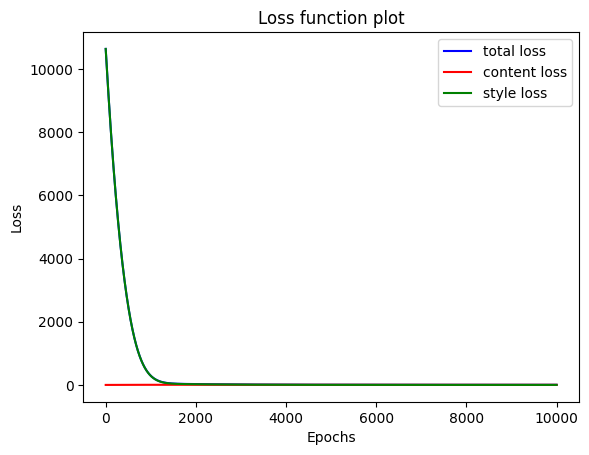

In [ ]:
# Plot loss1 in blue, loss2 in red and loss3 in green
x = np.arange(NST_num_of_steps)
plt.plot(x, loss_values, 'b', label = 'total loss')
plt.plot(x, content_loss_values, 'r', label = 'content loss')
plt.plot(x, style_loss_values, 'g', label = 'style loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.title("Loss function plot")
# Show the legend
plt.legend()
plt.show()

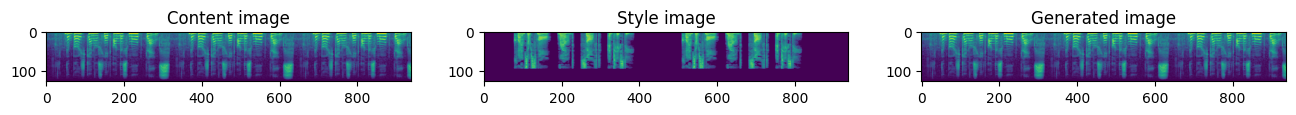

In [ ]:
# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(non_native_spectrogram)
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(native_spectrogram)
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image)
ax.title.set_text('Generated image')
plt.show()

In [ ]:
extended_generated_spectrogram_pradication = model.predict(extended_generated_spectrogram)
extended_non_native_spectrogram_pradication = model.predict(extended_non_native_spectrogram)
extended_native_spectrogram_pradication = model.predict(extended_native_spectrogram)

print("*************************************************************************************************************")
print(f"Model Prediction :: extended_generated_spectrogram_pradication - {extended_generated_spectrogram_pradication}")
print(f"Model Prediction :: extended_non_native_spectrogram - {extended_non_native_spectrogram_pradication}")
print(f"Model Prediction :: extended_native_spectrogram - {extended_native_spectrogram_pradication}")
print("*************************************************************************************************************")

1/1 [==============================] - 0s 32ms/step
*************************************************************************************************************
Model Prediction :: extended_generated_spectrogram_pradication - [[1.]]
Model Prediction :: extended_non_native_spectrogram - [[5.2720998e-17]]
Model Prediction :: extended_native_spectrogram - [[1.]]
*************************************************************************************************************


In [ ]:
# Save the generated audio
generated_spectrogram = np.squeeze(extended_generated_spectrogram.numpy())
target_aud , target_sr = librosa.load(target_audio_path, sr=None)
generated_audio = spectrogram_to_audio(generated_spectrogram, target_sr)


generated_file_name = '/content/drive/MyDrive/Colab Notebooks/CS230 Project/Generated_Audio_OLD/generated_audio_predicted_as_native=' + str(num_of_epochs) + str(
    datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.wav'
print("Saving generated audion as - " + generated_file_name)
write(generated_file_name, target_sr, generated_audio)

# original_aud_file_name = '/content/drive/MyDrive/Colab Notebooks/CS230 Project/Generated_Audio_OLD/original_aud=' + str(num_of_epochs) + str(
#     datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.wav'

Saving generated audion as - /content/drive/MyDrive/Colab Notebooks/CS230 Project/Generated_Audio_OLD/generated_audio_predicted_as_native=152023-06-06_05-23-35.wav


## VGG19

In [ ]:
import os
import pprint
from datetime import datetime
import librosa
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib.pyplot import imshow
from scipy.io import wavfile
from scipy.io.wavfile import write

In [ ]:
tf.random.set_seed(272)
pp = pprint.PrettyPrinter(indent=4)
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='imagenet')

vgg.trainable = False
pp.pprint(vgg)

80134624/80134624 [==============================] - 3s 0us/step


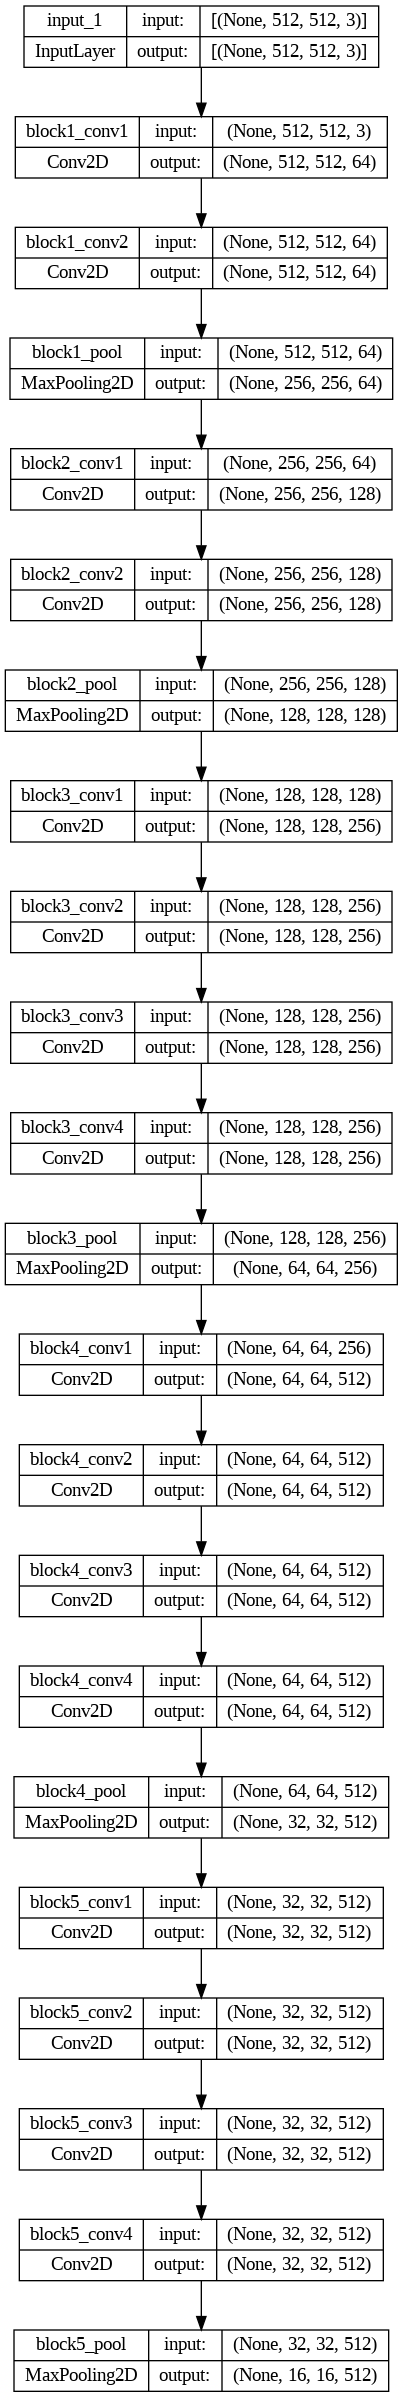

In [ ]:
plot_model(vgg, to_file='/content/drive/MyDrive/Colab Notebooks/CS230 Project/Results Plots/vgg_model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
for layer in vgg.layers:
    print(layer.name)

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost

    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

    Returns:
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]
    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C, shape=[_, n_H * n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[_, n_H * n_W, n_C])

    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled))) / (4 * n_H * n_W * n_C)

    return J_content


####################################################################################

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)

    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    return tf.linalg.matmul(A, tf.transpose(A))


####################################################################################

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns:
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W) (≈2 lines)
    a_S = tf.reshape(tf.transpose(a_S, perm=[0, 3, 1, 2]), shape=[n_C, n_H * n_W])
    a_G = tf.reshape(tf.transpose(a_G, perm=[0, 3, 1, 2]), shape=[n_C, n_H * n_W])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS, GG))) / (4 * (n_H * n_W * n_C) ** 2)

    return J_style_layer


def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers

    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them

    Returns:
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style


@tf.function()
def total_cost(J_content, J_style, alpha=10, beta=40):
    """
    Computes the total cost function

    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost

    Returns:
    J -- total cost as defined by the formula above.
    """
    return alpha * J_content + beta * J_style


# def LoadTheContentAndStyleSpectograms():


####################################################################################

def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1

    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image

    Arguments:
    tensor -- Tensor

    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [ ]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    print("vgg outputs is",outputs)
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
num_of_epochs = 4000
learning_rate = 0.01
img_size = 512
STYLE_LAYERS = [
    ('block1_conv1', 0.4),
    ('block2_conv1', 0.1),
    ('block3_conv1', 0.1),
    ('block4_conv1', 0.1),
    ('block5_conv1', 0.1)]

In [ ]:
content_layer = [('block5_conv4', 1)]
vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

vgg outputs is [<KerasTensor: shape=(None, 512, 512, 64) dtype=float32 (created by layer 'block1_conv1')>, <KerasTensor: shape=(None, 256, 256, 128) dtype=float32 (created by layer 'block2_conv1')>, <KerasTensor: shape=(None, 128, 128, 256) dtype=float32 (created by layer 'block3_conv1')>, <KerasTensor: shape=(None, 64, 64, 512) dtype=float32 (created by layer 'block4_conv1')>, <KerasTensor: shape=(None, 32, 32, 512) dtype=float32 (created by layer 'block5_conv1')>, <KerasTensor: shape=(None, 32, 32, 512) dtype=float32 (created by layer 'block5_conv4')>]


(-80.0, 0.0)

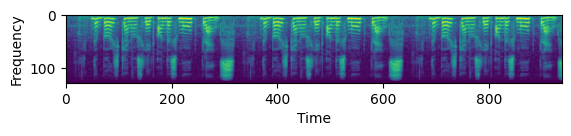

In [ ]:
log_magnitude_non_native = audio_to_spectrograms(non_native_path)[0]
# Plot the spectrogram
plt.imshow(log_magnitude_non_native)
plt.xlabel('Time')
plt.ylabel('Frequency')

spectrogram_original_height, spectrogram_original_width = log_magnitude_non_native.shape
np.min(log_magnitude_non_native), np.max(log_magnitude_non_native)


Text(0, 0.5, 'Frequency')

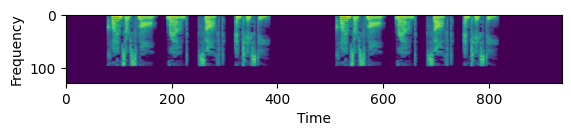

In [ ]:
log_magnitude_native = audio_to_spectrograms(native_path)[0]
# Plot the spectrogram
plt.imshow(log_magnitude_native)
plt.xlabel('Time')
plt.ylabel('Frequency')

In [ ]:
native = spect_2_vgg_input(log_magnitude_native)
non_native = spect_2_vgg_input(log_magnitude_non_native)
print(native.shape)
print(non_native.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


(1, 512, 512, 3)


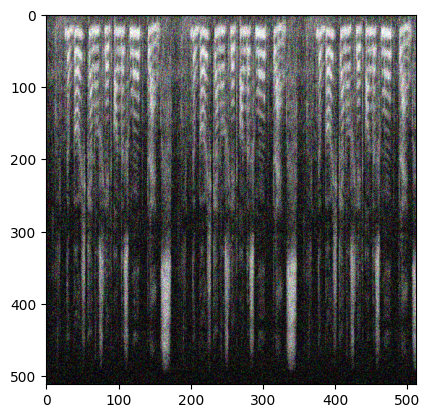

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(non_native, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
print(generated_image.shape)
imshow(generated_image.numpy()[0])
# plt.show(block=False)


# Assign the content image to be the input of the VGG model.
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content = tf.Variable(tf.image.convert_image_dtype(non_native, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

# Assign the input of the model to be the "style" image
preprocessed_style = tf.Variable(tf.image.convert_image_dtype(native, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # In this function you must use the precomputed encoded images a_S and a_C
        # Compute a_G as the vgg_model_outputs for the current generated image
        # (1 line)
        a_G = vgg_model_outputs(generated_image)

        # Compute the style cost
        # (1 line)
        J_style = compute_style_cost(a_S, a_G)

        # (2 lines)
        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)
        # Compute the total cost
        J = total_cost(J_content, J_style)

    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))
    # For grading purposes
    return J


generated_image = tf.Variable(generated_image)
loss_values = []
epochs = num_of_epochs
for i in range(epochs):

    J = train_step(generated_image)
    loss_values.append(J.numpy())
    if i % 250 == 0:
        print(f"Epoch {i} ")
        image = tensor_to_image(generated_image)
        imshow(image)
        plt.show()

### Evaluation

Epoch 0 
before imshow
Epoch 250 
before imshow
Epoch 500 
before imshow
Epoch 750 
before imshow
Epoch 1000 
before imshow
Epoch 1250 
before imshow
Epoch 1500 
before imshow
Epoch 1750 
before imshow
Epoch 2000 
before imshow
Epoch 2250 
before imshow
Epoch 2500 
before imshow
Epoch 2750 
before imshow
Epoch 3000 
before imshow
Epoch 3250 
before imshow
Epoch 3500 
before imshow
Epoch 3750 
before imshow


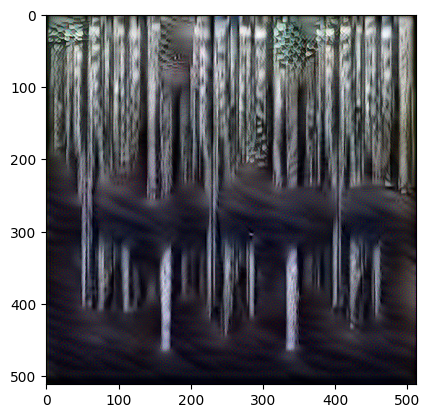

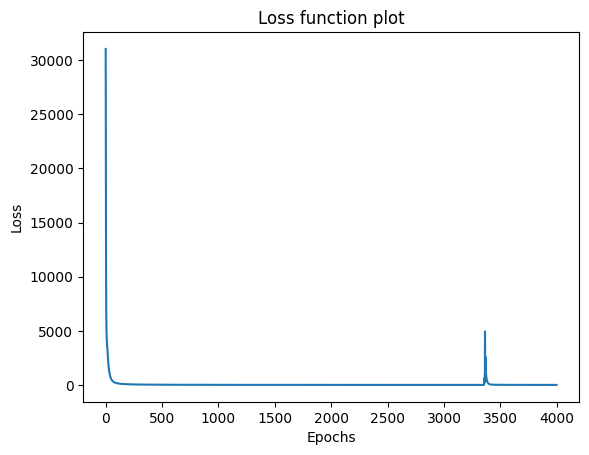

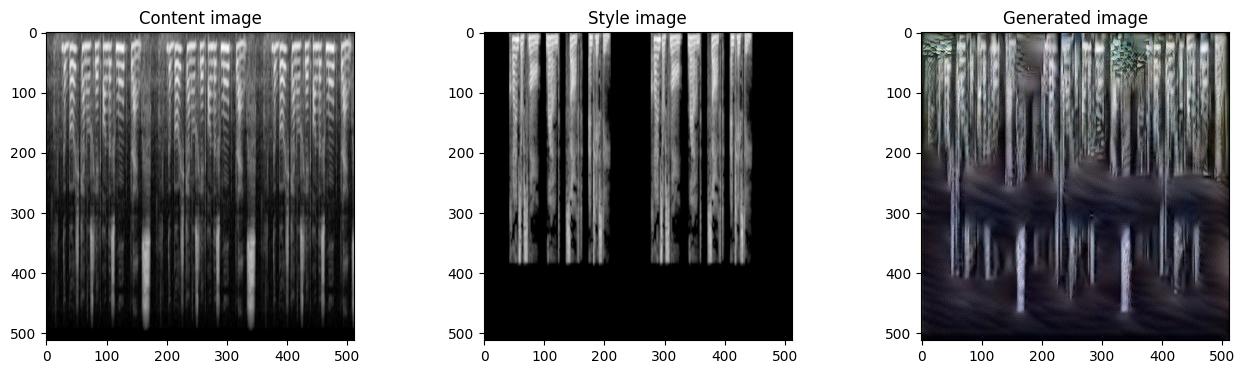

In [ ]:
# Plot the loss values against the epochs
plt.plot(range(epochs), loss_values)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss function plot")
plt.show()

# Show the 3 images in a row
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
imshow(non_native[0])
ax.title.set_text('Content image')
ax = fig.add_subplot(1, 3, 2)
imshow(native[0])
ax.title.set_text('Style image')
ax = fig.add_subplot(1, 3, 3)
imshow(generated_image[0])
ax.title.set_text('Generated image')
plt.show()


In [ ]:
# Save the generated audio
spectrogram = audio_to_spectrograms(target_audio_path)[0]
spectrogram_min = np.min(spectrogram)
spectrogram_max = np.max(spectrogram)

target_aud , target_sr = librosa.load(target_audio_path, sr=None)
spect = vgg_input_2_spect(generated_image,
                       spectrogram_original_height,
                       spectrogram_original_width,
                       spectrogram_min,
                       spectrogram_max)
generated_audio = spectrogram_to_audio(spect, target_sr)


generated_file_name = '/content/drive/MyDrive/Colab Notebooks/CS230 Project/Generated_Audio_OLD/vgg_generated_audio ' + str(num_of_epochs) + str(
    datetime.now().strftime('%Y-%m-%d_%H-%M-%S')) + '.wav'
print("Saving generated audion as - " + generated_file_name)
write(generated_file_name, target_sr, generated_audio)

Saving generated audion as - /content/drive/MyDrive/Colab Notebooks/CS230 Project/Generated_Audio_OLD/vgg_generated_audio 40002023-06-06_06-30-35.wav


Future work -

1. Add Dropout
2. Hyperparameter tuning
3. Use style matrix that created from multiple native audio
4. NST Style weights tuning
